# Handwritten digits recognition using CNN

This approach is inspired by article 'Multi-column Deep Neural Networks for Image Classification, Dan Cireşan, Ueli Meier, Juergen Schmidhuber, 2012' ([link](https://arxiv.org/abs/1202.2745)). The article describes currently (as in August 2017) the best performing model for handwritten digits recognition.
 
Since I don't have necessary hardware and/or time to train the model in original size I had to significantly scale things down. Therefore the results are not comparable to original paper. The approach presented here is just merely inspired by original work.

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Loading MNIST dataset

Keras offers a simple way for importing MNIST dataset. Let's use it.

In [2]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

print('Raw train input shape: {}'.format(x_train_raw.shape))
print('Raw train output shape: {}'.format(y_train_raw.shape))

print('Raw test input shape: {}'.format(x_test_raw.shape))
print('Raw test output shape: {}'.format(y_test_raw.shape))

Raw train input shape: (60000, 28, 28)
Raw train output shape: (60000,)
Raw test input shape: (10000, 28, 28)
Raw test output shape: (10000,)


Convolution layer which we will use expects every input sample to have three dimensions (width, height, depth). 

Therefore we need to transform x from (n, 28, 28) into (n, 28, 28, 1).

In [3]:
x_train = np.expand_dims(x_train_raw, axis=3)
x_test = np.expand_dims(x_test_raw, axis=3)

print('Train input shape: {}'.format(x_train.shape))
print('Test input shape: {}'.format(x_test.shape))

Train input shape: (60000, 28, 28, 1)
Test input shape: (10000, 28, 28, 1)


Also simple preprocessing is handy. We'd like to have all inputs between 0 and 1. 

But our dataset has values in range (0, 255), so we should scale all values in all samples.

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

Targets in 'y_test' and 'y_train' are numbers 0..9, but we need our targets to match 10 output neurons which we will use in our neural network (every one of them corresponds to one output number). 

We will transform target 'k' to one-hot-vector with length of 10 and value 1 on k-th position.

In [19]:
y_train = to_categorical(y_train_raw, 10)
y_test = to_categorical(y_test_raw, 10)

print('Train output shape: {}'.format(y_train.shape))
print('Test output shape: {}'.format(y_test.shape))

Train output shape: (60000, 10)
Test output shape: (10000, 10)


## Creating model using Keras library

In [6]:
def create_model(verbose=False):
    
    # define input and it's shape
    nn_input = Input(name='nn_input', shape=(28, 28, 1), dtype='float32')
    
    # first layer of convolution and pooling
    con_1 = Conv2D(filters=80, kernel_size=(5, 5), activation='tanh')(nn_input)
    pool_1 = MaxPooling2D(pool_size=(2, 2))(con_1)
    
    # second layer of convolution and pooling
    con_2 = Conv2D(filters=80, kernel_size=(3, 3), activation='tanh')(pool_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2))(con_2)
    
    # flatten outputs from previous layers in order to pass them to dense layers
    flatten = Flatten()(pool_2)
    
    # fully connected layers 
    dense_1 = Dense(80, activation='tanh')(flatten)
    dense_2 = Dense(10, activation='softmax')(dense_1)
    
    # model construction and compilation
    model = Model(inputs=nn_input, outputs=dense_2)
    model.compile(loss=categorical_crossentropy, 
                  optimizer=Adam(), 
                  metrics=['accuracy'])
    
    # print model architecture
    if verbose:
        model.summary()
    
    return model

Create our base model and print it's architecture.

In [7]:
single_nn = create_model(True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nn_input (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 80)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 80)        57680     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 80)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                160080    
__________

## Learning model from train data

We will use our train data to train 'single_nn' model. We will use Adam as a learning method. Learning stops after 50 epochs or once accuracy on validation data stops improving.

In [8]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4)
single_nn.fit(x_train, y_train, batch_size=256, epochs=50, 
              validation_split=0.05, callbacks=[es], verbose=1);

Train on 57000 samples, validate on 3000 samples
Epoch 1/50
57000/57000 [==============================] - 123s - loss: 0.2491 - acc: 0.9302 - val_loss: 0.0626 - val_acc: 0.9847
Epoch 2/50
57000/57000 [==============================] - 131s - loss: 0.0589 - acc: 0.9832 - val_loss: 0.0493 - val_acc: 0.9880
Epoch 3/50
57000/57000 [==============================] - 123s - loss: 0.0386 - acc: 0.9894 - val_loss: 0.0392 - val_acc: 0.9927
Epoch 4/50
57000/57000 [==============================] - 120s - loss: 0.0288 - acc: 0.9917 - val_loss: 0.0382 - val_acc: 0.9907
Epoch 5/50
57000/57000 [==============================] - 126s - loss: 0.0207 - acc: 0.9943 - val_loss: 0.0341 - val_acc: 0.9927
Epoch 6/50
57000/57000 [==============================] - 118s - loss: 0.0156 - acc: 0.9961 - val_loss: 0.0412 - val_acc: 0.9920
Epoch 7/50
57000/57000 [==============================] - 118s - loss: 0.0116 - acc: 0.9973 - val_loss: 0.0370 - val_acc: 0.9920
Epoch 8/50
57000/57000 [========================

## Testing on unseen data

First, define function for evaluation of a given model's ability to predict handwritten number on test data.

In [9]:
def test_model(model, verbose=False):
    predictions = model.predict(x_test, verbose=0)
    
    misclassified = []
    for x, y, p in zip(x_test_raw, y_test_raw, predictions):
        predicted_class = np.argmax(p)
        if predicted_class != y:
            # miss, remember missed sample
            misclassified.append((x, y, predicted_class))
    
    # calculate error rate
    error_rate = len(misclassified) / len(x_test) * 100
    
    if verbose:
        print('Error rate: {}%'.format(error_rate))
    
    return error_rate, misclassified

Perform the evaluation for 'single_nn' model.

In [10]:
result_single_nn = test_model(single_nn, True) 

Error rate: 0.83%


## Ensemble

Let's see how combination of several independently learned models performs.

First we create simple wrapper for the ensemble model.

In [11]:
class EnsembleModel:
    """Simple wrapper over Keras Model objects to provide simple API for 
    testing"""

    def __init__(self, models, combining_method='voting'):
        self.models = models

        if combining_method == 'voting':
            self.combinig_method = EnsembleModel.voting
        elif combining_method == 'averaging':
            self.combinig_method = EnsembleModel.averaging
        else:
            print('Unknown combining method:', combining_method)
            print('Fallback to voting.')
            self.combinig_method = EnsembleModel.voting

    def predict(self, x, batch_size=32, verbose=0):
        predictions = [m.predict(x, batch_size, verbose) for m in self.models]
        
        return self.combinig_method(predictions)

    @staticmethod
    def averaging(predictions):
        # sum all predictions
        final_prediction = np.zeros_like(predictions[0])
        for p in predictions:
            final_prediction = np.add(p, final_prediction)
        
        # normalize
        final_prediction /= final_prediction.sum(axis=1, keepdims=1)

        return final_prediction

    @staticmethod
    def voting(predictions):
        # sum all votes
        final_prediction = np.zeros_like(predictions[0])
        for p in predictions:
            one_hot = EnsembleModel._prediction_to_one_hot(p)
            final_prediction = np.add(one_hot, final_prediction)

        # normalize
        final_prediction /= final_prediction.sum(axis=1, keepdims=1)

        return final_prediction

    @staticmethod
    def _prediction_to_one_hot(prediction):
        one_hot = np.zeros_like(prediction)
        one_hot[np.arange(len(prediction)), prediction.argmax(1)] = 1
        
        return one_hot

We will independently train 4 models on train data in a same way we trained our 'single_nn' model.

In [12]:
n_models = 4
models = []
for i in range(n_models):
    print('Training model n. {}.'.format(i + 1))
    m = create_model()
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4)
    m.fit(x_train, y_train, batch_size=256, epochs=50, 
          validation_split=0.05, callbacks=[es], verbose=0);
    models.append(m)

Training model n. 1.
Training model n. 2.
Training model n. 3.
Training model n. 4.
Training model n. 5.


We can add 'single_nn' model as well.

In [13]:
models.append(single_nn)

Let's test all these models separately first in order to see the difference between individual models and ensemble.

In [14]:
for i, m in enumerate(models):
    print('Testing model number {}.'.format(i))
    test_model(m, True)

Testing model number 0.
Error rate: 0.75%
Testing model number 1.
Error rate: 1.02%
Testing model number 2.
Error rate: 1.01%
Testing model number 3.
Error rate: 0.9299999999999999%
Testing model number 4.
Error rate: 1.02%
Testing model number 5.
Error rate: 0.83%


Create ensemble model and test it's performance on test data with both averaging and voting scheme.

In [15]:
print('Creating and testing ensemble model with averaging scheme.')
em_a = EnsembleModel(models, 'averaging')
result_em_a = test_model(em_a, True)

Creating and testing ensemble model with averaging scheme.
Error rate: 0.77%


In [16]:
print('Creating and testing ensemble model with voting scheme.')
em_v = EnsembleModel(models, 'voting')
result_em_v = test_model(em_v, True)

Creating and testing ensemble model with voting scheme.
Error rate: 0.8%


## Plot missed samples

Just out of curiosity, let's see where our ensemble model with averaging scheme failed to predict correct target. 

We will plot all misclassified samples and label them 'T: A | P: B' where A is real target and B is prediction made by ensemble model.

In [17]:
def plot_misclassified(misclassified):    
    """Plots misclassified numbers in misclassified using matplotlib. 
    
    :param misclassified: List of misclassified numbers saved as triplet 
    (x, y, p), where x is array 28x28, y is real target and p is predicted 
    value.
    :return: None
    """
    
    w = 10
    h = int(math.ceil(len(misclassified) / w))
    f, ax = plt.subplots(h, w)
    f.set_figwidth(w)
    f.set_figheight(h)
    f.tight_layout()
    for p, miss in enumerate(misclassified):
        x, y, t = miss
        i, j = int(p / w), p % w

        ax[i][j].set_title('T: {} | P: {}'.format(y, t))
        fig = ax[i][j].imshow(np.reshape(x, (28,28)), cmap='gray');
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    # remove remaining subplots
    while j < w - 1:
        j += 1
        ax[i][j].axis('off')

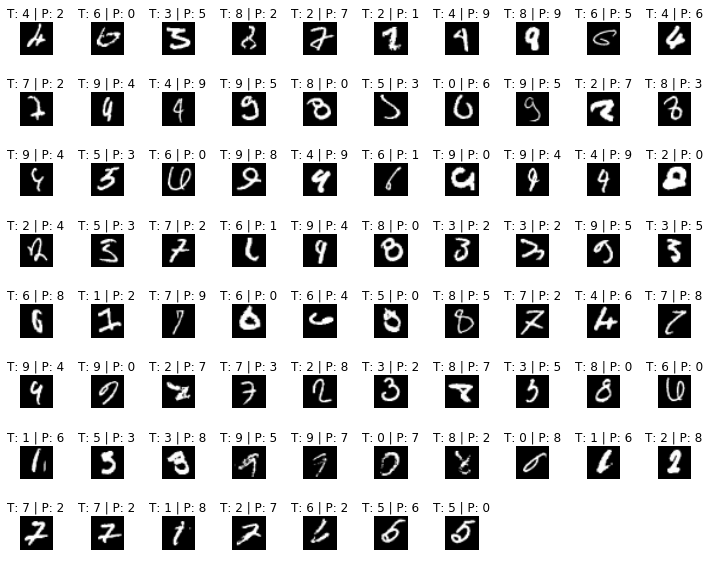

In [18]:
plot_misclassified(result_em_a[1])